In [244]:
# Initialize Otter
import otter
grader = otter.Notebook("covid_part2.ipynb")

## Goal

Model and analyze the temporal evolution of COVID-19 mortalities or cases using one unsupervised and one supervised technique of your choice. Interpret your models' results through visualizations, and draw insightful conclusions about the modeling of COVID-19 data.

Recall that we studied linear and logistic regression, decision trees, random forests as part of supervised learning (with labels) and clustering, PCA as part of unsupervised learning (without labels). You are free to use any methods that you find suitable to answer the problem at hand.

In [245]:
# Run this cell to set up your notebook
import numpy as np
from geopy import *
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.cluster import *
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from scipy.stats import pearsonr
import re

cases = pd.read_csv('data/time_series_covid19_confirmed_US.csv') # https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv
vaccinations = pd.read_csv('data/people_vaccinated_us_timeline.csv') # https://raw.githubusercontent.com/govex/COVID-19/master/data_tables/vaccine_data/us_data/time_series/people_vaccinated_us_timeline.csv
counties = pd.read_csv('data/co-est2020.csv', encoding='latin-1') # https://www2.census.gov/programs-surveys/popest/datasets/2010-2020/counties/totals/co-est2020.csv
mask_use = pd.read_csv('data/mask-use-by-county.csv') # https://github.com/nytimes/covid-19-data/blob/master/mask-use/mask-use-by-county.csv

<br/><br/><br/>

---

<br/><br/><br/>

## Data Cleaning (Again!)

For this section, please copy over the appropriate answers from your previous notebook submission.

### Part 1: Question 1a

Impute the null values in *all* the datasets with zero values or empty strings where appropriate.

<!--
BEGIN QUESTION
name: q1a
points: 0
-->

In [246]:
vaccinations = vaccinations.fillna(0)
cases['Admin2'] = cases['Admin2'].fillna('')
cases = cases.fillna(0)

In [247]:
grader.check("q1a")

q1a results: All test cases passed!

### Part 1: Question 1d

Generate a valid FIPS code for the `counties` table.

*Hint*: Refer to [this](https://transition.fcc.gov/oet/info/maps/census/fips/fips.txt) guide on FIPS codes.

<!--
BEGIN QUESTION
name: q1d
points: 0
-->

In [248]:
counties['FIPS'] = counties['STATE'] * 1000 + counties['COUNTY']

In [249]:
grader.check("q1d")

q1d results: All test cases passed!

### Part 1: Question 1e

Merge the `counties`, `cases`, and `mask_use` tables on an appropriate primary key to generate county-wise data.

<!--
BEGIN QUESTION
name: q1e
points: 0
-->

In [250]:
county_data = counties.merge(cases, on = 'FIPS').merge(mask_use, left_on = 'FIPS', right_on = 'COUNTYFP')

county_data

,SUMLEV,REGION,DIVISION,STATE,COUNTY,STNAME,CTYNAME,CENSUS2010POP,ESTIMATESBASE2010,POPESTIMATE2010,...,9/9/21,9/10/21,9/11/21,9/12/21,COUNTYFP,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS
0,50,3,6,1,1,Alabama,Autauga County,54571,54582,54761,...,9145,9207,9246,9287,1001,0.053,0.074,0.134,0.295,0.444
1,50,3,6,1,3,Alabama,Baldwin County,182265,182263,183121,...,34536,34726,34872,34950,1003,0.083,0.059,0.098,0.323,0.436
2,50,3,6,1,5,Alabama,Barbour County,27457,27454,27325,...,3243,3260,3282,3295,1005,0.067,0.121,0.120,0.201,0.491
3,50,3,6,1,7,Alabama,Bibb County,22915,22904,22858,...,3727,3752,3778,3795,1007,0.020,0.034,0.096,0.278,0.572
4,50,3,6,1,9,Alabama,Blount County,57322,57322,57372,...,9048,9095,9161,9176,1009,0.053,0.114,0.180,0.194,0.459
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3136,50,4,8,56,37,Wyoming,Sweetwater County,43806,43806,43580,...,6034,6111,6111,6111,56037,0.061,0.295,0.230,0.146,0.268
3137,50,4,8,56,39,Wyoming,Teton County,21294,21298,21298,...,4587,4611,4611,4611,56039,0.095,0.157,0.160,0.247,0.340
3138,50,4,8,56,41,Wyoming,Uinta County,21118,21121,21090,...,3168,3204,3204,3204,56041,0.098,0.278,0.154,0.207,0.264
3139,50,4,8,56,43,Wyoming,Washakie County,8533,8528,8531,...,1111,1120,1120,1120,56043,0.204,0.155,0.069,0.285,0.287


In [251]:
grader.check("q1e")

q1e results: All test cases passed!

<br/><br/><br/>

---

<br/><br/><br/>

## Question 5: Guided Supervised Modeling

This section will guide you through creating a supervised learning framework that will predict the number of COVID-19 cases per capita given various COVID-19 safety protocols that have been implemented. Then, we will investigate the bias, variance, and observational noise of this framework.

Note that any answer responses without the appropriate work (i.e. code or math) will be subject to additional review and will not receive any credit.

<!-- BEGIN QUESTION -->

### Question 5a

We will use county-wise mask usage data to predict the number of COVID-19 cases on September 12th, 2021. Create a visualization that shows the pairwise correlation between each combination of column in the mask usage data and the number of COVID-19 cases.

*Hint*: You should be plotting 36 correlations.
<!--
BEGIN QUESTION
name: q5a
points: 3
manual: True
-->

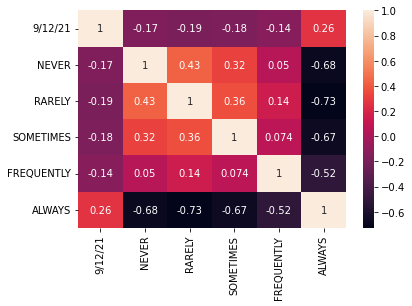

In [252]:
sns.heatmap(county_data[['9/12/21','NEVER','RARELY','SOMETIMES','FREQUENTLY','ALWAYS']].corr(), annot=True);

<!-- END QUESTION -->

### Question 5b

Train a linear regression model to predict the number of COVID-19 cases using county-wise mask usage data for September 12, 2021. Evaluate your model's RMSE on a held-out validation set with 33% of the county-wise data. When possible, make sure to set `random_state = 42` when splitting your data into training and test sets.
<!--
BEGIN QUESTION
name: q5b
points: 5
-->

In [253]:
X_q5b = county_data.iloc[:, -5:]
y_q5b = county_data['9/12/21']

def rmse(y, y_pred):
    return np.sqrt(np.mean((y-y_pred)**2))

# Make sure to set random_state = 42 and test_size = 0.33!
X_q5b_train, X_q5b_test = train_test_split(X_q5b, test_size = 0.33, random_state = 42)
y_q5b_train, y_q5b_test = train_test_split(y_q5b, test_size = 0.33, random_state = 42)

model = LinearRegression(fit_intercept=True)
model.fit(X_q5b_train, y_q5b_train)

y_q5b_train_predicted = model.predict(X_q5b_train)
y_q5b_test_predicted = model.predict(X_q5b_test)


train_rmse_cases = rmse(y_q5b_train, y_q5b_train_predicted)
test_rmse_cases = rmse(y_q5b_test, y_q5b_test_predicted)

train_rmse_cases, test_rmse_cases

(27834.430707426982, 62591.13087482178)

In [254]:
grader.check("q5b")

q5b results: All test cases passed!

<!-- BEGIN QUESTION -->

### Question 5c

Explain potential reasons the test set RMSE is much higher as compared to the training set RMSE.
<!--
BEGIN QUESTION
name: q5c
points: 3
manual: True
-->

The test set RMSE is higher potentially due to overfitting due to the test size being 33%. Another potential reason is because the correlation between the X and Y isn't that high as found in 5a, so the RMSE is higher. 

<!-- END QUESTION -->

### Question 5d

Instead of predicting the number of COVID-19 cases, redo part (b) by predicting the number of cases per capita. Report the model's RMSE on the training and validation set.

Comment on the relationship between the training and test RMSE by predicting the number of cases per capita instead of the total number of cases.
<!--
BEGIN QUESTION
name: q5d
points: 3
-->

In [255]:
X_q5d = county_data.iloc[:, -5:]
y_q5d = county_data['9/12/21'] / county_data['POPESTIMATE2020']
X_q5d_train, X_q5d_test =  train_test_split(X_q5d, test_size = 0.33, random_state = 42)
y_q5d_train, y_q5d_test =  train_test_split(y_q5d, test_size = 0.33, random_state = 42)


model = LinearRegression(fit_intercept=True)
model.fit(X_q5d_train, y_q5d_train)

y_q5d_train_predicted = model.predict(X_q5d_train)
y_q5d_test_predicted = model.predict(X_q5d_test)


train_rmse_cpc = rmse(y_q5d_train, y_q5d_train_predicted)
test_rmse_cpc = rmse(y_q5d_test, y_q5d_test_predicted)

train_rmse_cpc, test_rmse_cpc

(0.03540985737823185, 0.038167903498916037)

In [256]:
grader.check("q5d")

q5d results: All test cases passed!

<!-- BEGIN QUESTION -->

### Question 5e

Visualize the model outputs from part (d) by plotting the predictions $\hat{y}$ versus the observations $y$. Comment on what the plot indicates about our linear model as a comment in the code cell.

<!--
BEGIN QUESTION
name: q5e
points: 3
manual: True
-->

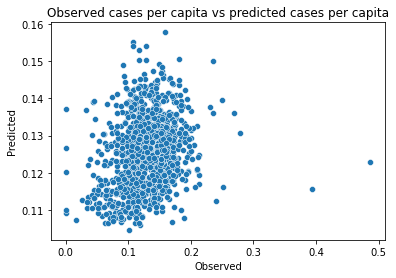

In [257]:
sns.scatterplot(y_q5d_test, y_q5d_test_predicted)
plt.xlabel('Observed')
plt.ylabel('Predicted')
plt.title('Observed cases per capita vs predicted cases per capita');
# The plot indicates that the model underpredicts the cases per capita

<!-- END QUESTION -->

### Question 5f

We will investigate the bias and variance of this improved model on the test set using the bias-variance decomposition to formalize the behaviour of our model. To generate an empirical estimate of the errors and the parameters in the bias-variance decomposition, train 1000 bootstrapped models on the training dataset from part (d).

<!--
BEGIN QUESTION
name: q5f
points: 5
-->

In [258]:
models = []
for i in range(1000):
    bootstrapped_X = X_q5d_train.sample(n = len(X_q5d_train), replace = True)
    bootstrapped_y = y_q5d_train[bootstrapped_X.index]
    model = LinearRegression(fit_intercept = True)
    model.fit(bootstrapped_X, bootstrapped_y)
    models.append(model)

In [259]:
grader.check("q5f")

q5f results: All test cases passed!

### Question 5g

To investigate the variance in our test predictions, we sample a particular test point $(x_i, y_i)$ such that $i = 100$. In other words, we will use the 100th point in the test set from part (d), `(X_q5d_test.iloc[100], y_q5d_test.iloc[100])` as the testing point.

Generate predictions and square errors for this test point for all 1000 models, and calculate the *proportion* of the *expected* square error that is captured by the model prediction variance. In other words, we wish to estimate the following quantity:

$$
\frac{\mathrm{Var}(f_\theta(x_i))}{\mathrm{E}_\theta[(y_i - f_\theta(x_i))^2]}
$$

*Hint*: Refer to the bias-variance decomposition from lecture.
<!--
BEGIN QUESTION
name: q5g
points: 5
-->

In [260]:
predictions = []
sq_errors = []
for m in models:
    pred = m.predict(np.array([X_q5d_test.iloc[100, :]]))
    predictions.append(pred)
    se = (y_q5d_test[100] - pred)**2
    sq_errors.append(se)
    
variation = np.var(predictions)
exp_sq_error = np.mean(sq_errors)
prop_var = variation / exp_sq_error

prop_var

0.0009765371044013854

In [261]:
grader.check("q5g")

q5g results: All test cases passed!

<!-- BEGIN QUESTION -->

### Question 5h

Using the bias-variance decomposition, comment on how much the variance of the model contributes to the error on the sample point above. We will extend this scenario to analyze the noise term in the bias-variance decomposition, specifically with regards to this COVID-19 dataset. Consider the following:

i) Assuming no observational noise (i.e. $\epsilon = 0$), what is the *magnitude* of the empirical model bias on this sample point?

ii) Clearly, there is a non-trivial amount of observational noise with COVID-19 case data simply due to how testing works and occurs. Please take a look at [this article](https://fivethirtyeight.com/features/coronavirus-case-counts-are-meaningless/) for more information. Given this infomation, explain the issues with the assumptions and result in 5h(i).

iii) Recall that we typically assume $y = g(x) + \epsilon$, where $\epsilon \sim \mathcal{N}(\mu, \sigma)$. In the theoretical setting for bias-variance, we have assumed $\mu = 0, \sigma > 0$. In this practical setting, analyze and determine how $\epsilon$ could be modeled (as a normal distribution, but you may also consider how it could be modeled as another distribution). Are there any immediate issues with the assumptions we have made in the theoretical setting where $\mu = 0, \sigma > 0$? What conditions on $\mu, \sigma$ could be more appropriate and why?

iv) Does the standard bias-variance decomposition presented in lecture hold given $\epsilon$ being normally distributed according to your answer in part (iii)? If so, please explain why. If not, explain why it does not hold and if possible, how to modify the bias-variance decomposition to make it hold (i.e. perhaps there is an additional noise term $E[\epsilon^3]$). 

*Hint*: Try to express $y = g(x) + \epsilon$ by adding and subtracting a certain quantity.

v) Intuitively, is it possible to minimize the true model bias to 0 given your $\epsilon$ formulation in part (iii)? Why or why not? Justify your answer using part (iv) if possible.

vi) Consider the infinite sample case where an oracle grants you as many samples as requested, and answer the same question in part (v). Is it possible to minimize the true model bias to 0 given your $\epsilon$ formulation in part (iii)? Conclude with an analysis of what our modeling task can approximate using $X\theta \approx y$ in the finite and infinite sample case.

<!--
BEGIN QUESTION
name: q5h
points: 24
manual: True
-->

i) random noise is only one component of a model's error. Without any observational noise, there is still the variance between the ground truth and the model (g(x) - Yhat). This bias is due to the sample points chosen to fit the model, so while the overall bias will be smaller, it is not 0.

ii) as stated in the article, testing patterns are a large source of observational noise when it comes to COVID case data. We therefore cannot assume that there is 0 observational noise and the magnitude of model bias is larger than we anticipated in 5h(i). This is particularly because it's not necessarily random as the amount of tests being conducted can be scaled up or down and not be representative of how many cases there are in an area.

iii) The issue with this assumption is that, as per the article, the data isn't actually centered around 0. Additionally, the noise isn't necessarily random, so better values of mu and sigma would take postitive cases in proportion to tests given into account. One condition on $\mu$ that might be more appropriate is assuming $\mu < 0$ since the article indicated that Covid-19 were being undercounted due to systematic error.

iv) Since the noise $\epsilon$ is nonrandom, the standard bias-variance decomposition presented in lecture would not hold, as $E(\epsilon) \neq 0$ in this scenario and given the condition in part (iii).  
We can modify the bias-variance decomposition to make it hold by adding and subtracting $\mu$ to $y = g(x) + \epsilon$. A rederivation can then be done, since $E(\epsilon -\mu)$ is now equal to 0

\begin{gather*}
Y = g(x) + \mu + \epsilon - \mu \\
g'(x) = g(x) + \mu \\
\epsilon' = \epsilon - \mu
\end{gather*}

  
we can sub in $g'(x)$ and $\epsilon'$ to the bias-variance decomposition from lecture to get:

\begin{align*}
\mathbb{E}\big{(} (Y - \hat{Y}(x))^{2} \big{)} ~ & = ~ \mathbb{E}((\epsilon')^2) + \mathbb{E}\big{(} (g'(x) - \mathbb{E}(\hat{Y}(x))^2\big{)} + \mathbb{E}\big{(} (\hat{Y}(x) - \mathbb{E}(\hat{Y}(x))^{2} \big{)} \\
&= ~ \sigma^2 + \mathbb{E}\big{(} ((g(x) + \mu) - \mathbb{E}(\hat{Y}(x))^2\big{)} + \mathbb{E}\big{(} (\hat{Y}(x) - \mathbb{E}(\hat{Y}(x))^2 \big{)}
\end{align*}


v) It does not seem possible to minimize the true model bias to 0. Since $\mu$ is now unknown, our modification to the bias-variance decomposition means that it cannot be minimized to 0.

vi) In the infinite and finite sample case, it is still not possible for the model bias to be minimized to 0. This is because our modifications make it so we cannot approximate $g(x)$, only approximate $g'(x)$ can be approximated

<!-- END QUESTION -->

### Question 5i

Using the bias-variance decomposition for each test point, calculate the average variance and average test mean-square error across the entire test set from part (d). In other words, estimate the following quantities:

$$
\frac{1}{n} \sum_i \mathrm{Var}(f_\theta(x_i))
$$

and

$$
\frac{1}{n} \sum_i \mathrm{E}_\theta[(y_i - f_\theta(x_i))^2]
$$

<!--
BEGIN QUESTION
name: q5i
points: 5
manual: False
-->

In [262]:
var = []
mses = []
for i, row in X_q5d_test.iterrows():
    predictions = []
    sq_errors = []
    for m in models:
        pred = m.predict(np.array([row]))
        predictions.append(pred)
        se = (y_q5d_test.loc[i] - pred)**2
        sq_errors.append(se)

    variation = np.var(predictions)
    exp_sq_error = np.mean(sq_errors)
    
    var.append(variation)
    mses.append(exp_sq_error)

avg_var = np.mean(var)
avg_mse = np.mean(mses)
avg_var, avg_mse


(4.000309696121709e-06, 0.0014608114130877266)

In [263]:
grader.check("q5i")

q5i results: All test cases passed!

<!-- BEGIN QUESTION -->

## Question 5j

Propose a solution to reducing the mean square error using the insights gained from the bias-variance decomposition above. What are the values of the quantities that have we estimated and what can be concluded about the remaining quantities? Please show all work that informs your analysis.

Assume that the standard bias-variance decomposition used in lecture can be applied here.
<!--
BEGIN QUESTION
name: q5j
points: 5
manual: True
-->

One solution to reducing the mean square error (model risk) is to use regularization to control the bias and variance to avoid over and underfitting. The quantities that we have estimated for the bias-variance decomposition are the average mse (model risk) and average variance (model variance). Since the average mse in 5i is very close to 0, it can be conclusded that the sum of the remaining quantities in the bias variance decomposition from lecture (observation variance and model bias squared) is roughly -4 since the model variance was calculated to be 4

<!-- END QUESTION -->



<br/><br/><br/>

---

<br/><br/><br/>

## Question 6: Open Supervised Modeling

We wish to extend our modeling framework from Question 5 to make it more accurate; in other words, we wish to predict $f(x)$, a supervised learning output, based on past and current quantities. 

This section will serve as a rough guide on creating an autoregressive modeling framework for predicting a COVID-19 quantity of your choice (i.e. deaths, cases, vaccinations).

Note that if you do not wish to pursue time-based modeling of COVID-19, you may skip parts (d), (e), and (f). That being said, you are strongly encouraged to incorporate time-based modeling into your open-ended modeling design since it constitutes a large component of the provided datasets.

We will ***not*** grade these below questions individually (i.e. there are no points explicitly assigned to questions 6(a) to 6(f)); they are simply guiding questions and will be graded as part of the final project report. You should make sure to answer all of the questions (that are applicable to your open-ended modeling) in some form in the report.

<!-- BEGIN QUESTION -->

### Question 6a

Train a baseline model where $f$ is the model described in Question 0a and $x$ is a quantity of *your* choice. Note that you may used *any* supervised learning approach we have studied; you are not limited to a linear model.

<!--
BEGIN QUESTION
name: q6a
points: 0
manual: True
-->

In [264]:
#Logistic Regression Model - model testing
from sklearn.linear_model import LogisticRegression

def get_party(diff):
    # True for GOP, False for Democratic Party
    if diff > 0:
        return True
    else:
        return False

election_results = pd.read_csv('data/election_results.csv')
election_results['voted_GOP'] = election_results['per_point_diff'].apply(get_party)
county_complete = pd.read_csv('data/county_complete.csv')
county_complete = county_complete[['fips', 'area_2010']]
county_data_copy = county_data.copy()
county_data_copy['area'] = county_data.merge(right = county_complete, left_on = 'COUNTYFP', right_on = 'fips')['area_2010']
county_data_copy['population_density'] = county_data_copy['POPESTIMATE2020'] / county_data_copy['area']
covid_and_election = county_data_copy.merge(right=election_results, left_on='COUNTYFP', right_on='county_fips')
covid_and_election['covid_per_cap'] = covid_and_election['11/1/20'] / covid_and_election['POPESTIMATE2020']

X = covid_and_election[['NEVER','RARELY','SOMETIMES','FREQUENTLY','ALWAYS', 'covid_per_cap', 'population_density']]
Y = covid_and_election['voted_GOP']

x_train, x_test,y_train,y_test = train_test_split(X,Y, test_size=0.2, random_state=42)
lr = LogisticRegression(fit_intercept=True, solver = 'lbfgs')
lr.fit(x_train,y_train) 
train_accuracy = sum(lr.predict(x_train) == y_train) / len(x_train)
test_accuracy = sum(lr.predict(x_test) == y_test) / len(x_test)

train_accuracy, test_accuracy 

(0.8842908798714343, 0.8539325842696629)

In [265]:
election_data = pd.read_csv("data/election_results.csv")
population_data = pd.read_csv("data/county_complete.csv")

model_data = county_data.merge(election_data, 'inner',left_on='COUNTYFP', right_on='county_fips')
model_data = model_data.drop(['county_name', 'state_name', 'county_fips', 'CENSUS2010POP', 'ESTIMATESBASE2010', 'POPESTIMATE2010', 'POPESTIMATE2011', 'POPESTIMATE2012', 'POPESTIMATE2013', 'POPESTIMATE2014', 'POPESTIMATE2015', 'POPESTIMATE2016', 'POPESTIMATE2017', 'POPESTIMATE2018', 'POPESTIMATE2019'], axis=1)
model_data = model_data[model_data['STNAME'] != 'Alaska']

model_data['Dem'] = model_data['per_dem'] >= model_data['per_gop']
model_data['median_increase'] = np.median(np.diff(model_data.iloc[:,20:305]), axis=1)
model_data['total cases'] = np.sum(model_data.iloc[:,20:305], axis=1) / model_data['POPESTIMATE2020']
model_data = model_data.merge(population_data, 'inner', left_on='COUNTYFP', right_on='fips')
model_data['density'] = model_data['POPESTIMATE2020'] / model_data['area_2010']
model_data['NRS'] = model_data['NEVER'] + model_data['RARELY'] + model_data['SOMETIMES']


model_data['Dem'] = model_data['per_dem'] >= model_data['per_gop']
model_data['total cases'] = np.sum(model_data.iloc[:,20:305], axis=1) / model_data['POPESTIMATE2020']

from sklearn import ensemble
train, test = train_test_split(model_data, test_size=0.25, random_state = 24)
random_forest_model1 = ensemble.RandomForestClassifier(n_estimators=20, random_state = 24)
random_forest_model1.fit(train[['ALWAYS', 'total cases', 'NEVER']], train['Dem'])

rf_train_accuracy1 = random_forest_model1.score(train[['ALWAYS', 'total cases', 'NEVER']], train['Dem'])
rf_test_accuracy1 = random_forest_model1.score(test[['ALWAYS', 'total cases', 'NEVER']], test['Dem'])

rf_train_accuracy1, rf_test_accuracy1

(0.9940017137960583, 0.877892030848329)

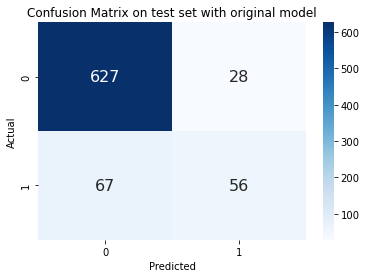

In [266]:
from sklearn.metrics import confusion_matrix

y_pred_test = random_forest_model1.predict(test[['ALWAYS', 'total cases', 'NEVER']])
cm = confusion_matrix(test['Dem'], y_pred_test)
sns.heatmap(cm, annot=True, fmt = 'd', cmap = 'Blues', annot_kws = {'size': 16})
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix on test set with original model');

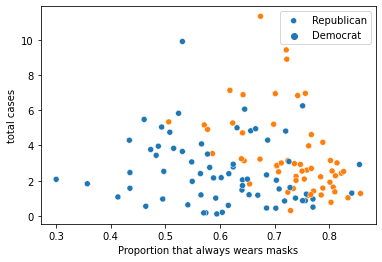

In [267]:
test['prediction'] = y_pred_test.astype(int)
dem_counties = test[test['Dem'] == 1]
sns.scatterplot(x=dem_counties['ALWAYS'], y=dem_counties['total cases'], hue = dem_counties['prediction']);
plt.xlabel('Proportion that always wears masks')
plt.legend(["Republican", "Democrat"]);

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 6b

Improve your model from part (a). Specify the supervised model you choose and write $f(x)$ as a function of the chosen features and parameters in your model. Justify why you chose these features and how you expect they will correlate with the output you wish to predict.

<!--
BEGIN QUESTION
name: q6b
points: 0
manual: True
-->

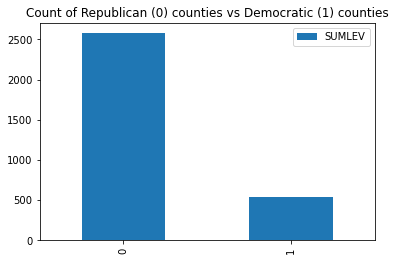

In [279]:
new5 = model_data.groupby('Dem').count()[['SUMLEV']].reset_index(level=0)
new5.plot.bar(title='Count of Republican (0) counties vs Democratic (1) counties');

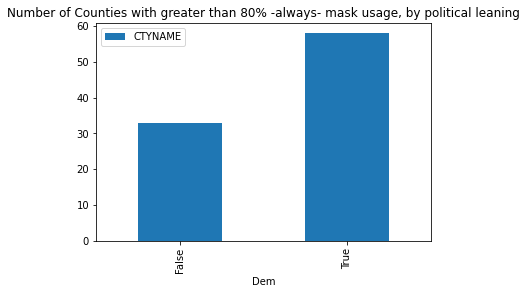

In [280]:
plt = model_data[model_data['ALWAYS'] >= .8][['CTYNAME', 'Dem']].groupby('Dem').count().plot.bar(title = 'Number of Counties with greater than 80% -always- mask usage, by political leaning')

In [268]:
from sklearn.model_selection import cross_validate
cols = model_data.iloc[:,20:305].columns.tolist() + ['POPESTIMATE2020','ALWAYS','density', 'median_increase', 'total cases', 'NRS']
X = train[cols]
y = train['Dem']
clf = ensemble.RandomForestClassifier(n_estimators=20, random_state = 24)
output = cross_validate(clf, X, y, cv=5, scoring = 'accuracy', return_estimator =True)
for idx,estimator in enumerate(output['estimator']):
    print("Features sorted by their score for estimator {}:".format(idx))
    feature_importances = pd.DataFrame(estimator.feature_importances_,
                                       index = X.columns,
                                        columns=['importance']).sort_values('importance', ascending=False)
    print(feature_importances)

Features sorted by their score for estimator 0:
                 importance
NRS                0.036544
POPESTIMATE2020    0.033941
ALWAYS             0.027585
3/22/20            0.024891
4/12/20            0.023958
...                     ...
1/23/20            0.000000
2/15/20            0.000000
2/14/20            0.000000
2/13/20            0.000000
1/22/20            0.000000

[291 rows x 1 columns]
Features sorted by their score for estimator 1:
                 importance
NRS                0.044203
POPESTIMATE2020    0.038461
3/30/20            0.029530
ALWAYS             0.025167
density            0.024144
...                     ...
2/14/20            0.000000
2/13/20            0.000000
2/12/20            0.000000
3/8/20             0.000000
1/22/20            0.000000

[291 rows x 1 columns]
Features sorted by their score for estimator 2:
                 importance
POPESTIMATE2020    0.034037
ALWAYS             0.033856
density            0.028230
NRS                0.027

In [269]:
random_forest_model2 = ensemble.RandomForestClassifier(n_estimators=20, random_state = 24)
random_forest_model2.fit(train[['POPESTIMATE2020','ALWAYS', '11/1/20', 'density','3/22/20', 'total cases', 'NRS']], train['Dem'])

rf_train_accuracy2 = random_forest_model2.score(train[['POPESTIMATE2020','ALWAYS', '11/1/20', 'density','3/22/20', 'total cases', 'NRS']], train['Dem'])
rf_test_accuracy2 = random_forest_model2.score(test[['POPESTIMATE2020','ALWAYS', '11/1/20', 'density','3/22/20', 'total cases', 'NRS']], test['Dem'])
rf_train_accuracy2, rf_test_accuracy2

(0.99528706083976, 0.910025706940874)

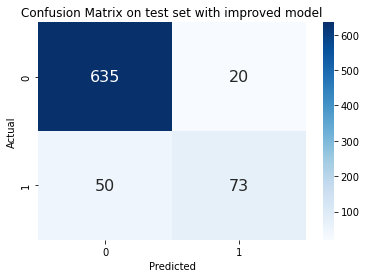

In [270]:
y_pred2 = random_forest_model2.predict(test[['POPESTIMATE2020','ALWAYS', '11/1/20', 'density','3/22/20', 'total cases', 'NRS']])
cm2 = confusion_matrix(test['Dem'], y_pred2)
sns.heatmap(cm2, annot=True, fmt = 'd', cmap = 'Blues', annot_kws = {'size': 16})
plt.xlabel('Predicted')
plt.ylabel('Actual');
plt.title('Confusion Matrix on test set with improved model');

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 6c

If applicable, write an equation or rule for the prediction function $f(x)$; if this is infeasible, make sure to visualize your model parameters in some way. Interpret your improved model's optimal parameters (*hint*: refer to 1aiii), and compare these parameters to those of the baseline model. Comment on whether the parameters follow physical intuition given the nature of the prediction task.

For example, if you chose to use a decision tree, you may interpret the generated rules.
 
<!--
BEGIN QUESTION
name: q6c
points: 0
manual: True
-->

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 6d

Discuss your improved model's performance on both short-term and long-term time scales using a metric of your choice (*hint:* we're using an autoregressive model). In other words, given $x_t$, we wish to predict $\hat{x}_{t+k}$, and plot the error of these predictions for two $k$ values of your choice. You may use any reasonable interpretation of short-term and long-term predictions; an initial suggestion is to use 2-day predictions and 2-week predictions.

Compare the performance of this model on both timescales with the baseline model.

<!--
BEGIN QUESTION
name: q6d
points: 0
manual: True
-->

In [271]:
...

Ellipsis

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 6e

Plot and describe the error for both the baseline and improved models as a function of time. In other words, given $x_t$, we wish to predict $\hat{x}_{t+k}$, and plot the error of these predictions for all $k$.

Consider how and why the performance of the model degrades as a function of time using the rate of growth in the error.

<!--
BEGIN QUESTION
name: q6e
points: 0
manual: True
-->

In [272]:
...

Ellipsis

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 6f

Consider a modification to the model $f(x) = x_{t+1}$ where instead $f(x) = [x_{t+1}, x_{t+2}, ..., x_{t+m}]$ for some $m > 1$. In other words, using the features $x$ that contain past and present quantities, our model *explicitly* predicts values for $m$ days in the future rather than simply the next day (i.e. $m = 1$). 

Train the baseline and improved model using $m = 5$ and $m = 10$. Evaluate and visualize the predictive accuracy of both models.

<!--
BEGIN QUESTION
name: q6f
points: 0
manual: True
-->

In [273]:
...

Ellipsis

---

To double-check your work, the cell below will rerun all of the autograder tests.

In [274]:
grader.check_all()

q1a results: All test cases passed!

q1d results: All test cases passed!

q1e results: All test cases passed!

q5b results: All test cases passed!

q5d results: All test cases passed!

q5f results: All test cases passed!

q5g results: All test cases passed!

q5i results: All test cases passed!

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [276]:
# Save your notebook first, then run this cell to export your submission.
grader.export()